We complete this lab as a group of three. All group members contributed equally.

    Willem Meijer (willem.meijer@liu.se)  
    Yikun Hou (yikun.hou@umu.se)  
    Yiran Wang (yiran.wang@liu.se)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import random
from collections import deque, namedtuple
from utilities import OUNoise, OUActionNoise

import gymnasium as gym
import copy
from plotting import plot_losses, plot_score
from torch.distributions import MultivariateNormal, Normal

In [2]:
class DDPG_actor(nn.Module):
    def __init__(self, state_size, action_size, layer_size):
        super(DDPG_actor, self).__init__()

        self.state_size = state_size
        self.fca1 = nn.Linear(self.state_size, layer_size)
        self.fca2 = nn.Linear(layer_size, layer_size)
        """Start your code here. 1 line of code"""
        self.action_values = nn.Linear(layer_size, action_size)
        """End your code here"""


    def forward(self, state):
        x = torch.relu(self.fca1(state))
        x = torch.relu(self.fca2(x))

        # Policy
        """Start your code here. 1 line of code."""
        action_value = 2 * torch.tanh(self.action_values(x)) # tanh normalize output to [-1, 1] but we need [-2, 2]
        """End your code here."""
        return action_value

In [3]:
class DDPG_critic(nn.Module):
    def __init__(self, state_size, action_size, layer_size):
        super(DDPG_critic, self).__init__()

        self.state_size = state_size
        self.action_size = action_size

        self.fcs1 = nn.Linear(self.state_size, 16)
        self.fcs2 = nn.Linear(16, 32)

        self.fcu2 = nn.Linear(self.action_size, 32)

        self.fcc3 = nn.Linear(64, layer_size)
        self.fcc4 = nn.Linear(layer_size, layer_size)

        """Start your code here. 1 line of code."""
        self.qvalue = nn.Linear(layer_size, 1) # Q is a scalar
        """End your code here"""

    def forward(self, state, action):
        x = torch.relu(self.fcs1(state))
        x = torch.relu(self.fcs2(x))

        u = torch.relu(self.fcu2(action))

        z = torch.cat([x, u], 1)

        z = torch.relu(self.fcc3(z))
        z = torch.relu(self.fcc4(z))
        """Start your code here. 1 line of code."""
        Q = self.qvalue(z)
        """End your code here."""
        return Q

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, gamma):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.gamma = gamma

        self.n_step_buffer = deque(maxlen=1)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""

        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == 1:
            state, action, reward, next_state, done = self.calc_multistep_return()

            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)

    def calc_multistep_return(self):
        Return = 0
        for idx in range(1):
            Return += self.gamma ** idx * self.n_step_buffer[idx][2]

        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], Return, self.n_step_buffer[-1][3], \
        self.n_step_buffer[-1][4]

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(
            self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class DDPG_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 layer_size,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR_critic,
                 LR_actor,
                 TAU,
                 GAMMA,
                 device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.BATCH_SIZE = BATCH_SIZE
        self.noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))

        # Q-Networks
        self.qnetwork_local = DDPG_critic(state_size, action_size, layer_size).to(device)
        self.qnetwork_target = DDPG_critic(state_size, action_size, layer_size).to(device)
        self.optimizer_critic = optim.Adam(self.qnetwork_local.parameters(), lr=LR_critic)

        # Actor-Networks
        self.actor_network_local = DDPG_actor(state_size, action_size, layer_size).to(device)
        self.actor_network_target = DDPG_actor(state_size, action_size, layer_size).to(device)
        self.optimizer_actor = optim.Adam(self.actor_network_local.parameters(), lr=LR_actor)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, self.GAMMA)



    def get_action(self, state):
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_network_local.eval()
        with torch.no_grad():
            action = self.actor_network_local(state.unsqueeze(0))
            noise = self.noise()
            action = action.cpu().squeeze().numpy() + noise
            action = np.clip(action, -2, 2)[0]
        self.actor_network_local.train()
        return action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        """

        # Unpack the sampled data
        states, actions, rewards, next_states, dones = experiences

        ## Critic network
        self.optimizer_critic.zero_grad()

        with torch.no_grad():
            # The Q from the target network
            next_inputs = self.actor_network_target(next_states)
            Q_network_ = self.qnetwork_target(next_states, next_inputs)

        """Start your code here. 3 lines of code."""
        # The target Q for the current state using the target V
        Q_targets = rewards + (self.GAMMA * Q_network_ * (1 - dones))

        # The Q from the local network. We should find the gradient so we do not put it in no_grad
        Q = self.qnetwork_local(states, actions)

        # Compute the critic loss
        loss_critic = F.mse_loss(Q, Q_targets)
        """End your code here."""

        loss_critic.backward()
        # clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        self.optimizer_critic.step()

        ## Actor network
        self.optimizer_actor.zero_grad()

        """Start your code here. 3 lines of code."""
        actions_local = self.actor_network_local(states)
        q_local = self.qnetwork_local(states, actions_local)
        loss_actor = -q_local.mean()
        """End your code"""

        # Minimize the critic and actor losses
        loss_actor.backward()
        self.optimizer_actor.step()


        # ------------------- update target network ------------------- #
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.TAU * local_param.data + (1.0 - self.TAU) * target_param.data)

        # ------------------- update target network ------------------- #
        for target_param, local_param in zip(self.actor_network_target.parameters(), self.actor_network_local.parameters()):
            target_param.data.copy_(self.TAU * local_param.data + (1.0 - self.TAU) * target_param.data)

        # self.noise.reset()

        return loss_critic.detach().cpu().numpy()

    def rollout(self, env):
        state, info = env.reset()
        done = False
        truncated = False
        score = 0.0
        loss = 0.0
        Q_losses = []
        while not (done or truncated):

            # Get the action
            action = self.get_action(state)

            # Apply the action
            next_state, reward, done, truncated, _ = env.step(np.array([action]))

            # Add the sample to the memory
            self.memory.add(state, action, reward, next_state, done)

            # Sample from buffer and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                Q_losses.append(loss)
                #writer.add_scalar("Q_loss", np.mean(Q_losses))
                loss = np.mean(Q_losses)

            # Update the new state and score
            state = next_state
            score += reward
        return score, loss

In [6]:
def run_ddpg(env):
    #writer = SummaryWriter("runs/" + "DDPG_test")
    seed = 0
    LAYER_SIZE = 256 # Original: 256
    BUFFER_SIZE = 50000 # Original: 50000
    BATCH_SIZE = 128 # Original: 128
    GAMMA = 0.99 # Original: 0.99
    TAU = 0.005 # Original: 0.005
    LR_critic = 0.002 # Original: 0.002
    LR_actor = 0.001 # Original: 0.001
    NUMBER_OF_EPISODES = 200
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using ", device)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    action_size = env.action_space.shape[0]
    state_size = env.observation_space.shape[0]

    agent = DDPG_Agent(state_size=state_size,
                        action_size=action_size,
                        layer_size=LAYER_SIZE,
                        BATCH_SIZE=BATCH_SIZE,
                        BUFFER_SIZE=BUFFER_SIZE,
                        LR_critic=LR_critic,
                        LR_actor=LR_actor,
                        TAU=TAU,
                        GAMMA=GAMMA,
                        device=device)

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(NUMBER_OF_EPISODES):
        # Run a rollout
        score, _ = agent.rollout(env)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        if i_episode % 5 == 0:
            print('\rEpisode {} \tTotal reward: {:.2f} \tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
    plot_score(scores)

Using  cpu
Episode 0 	Total reward: -1125.11 	Average Score: -1125.11
Episode 5 	Total reward: -1732.76 	Average Score: -1259.65
Episode 10 	Total reward: -1305.96 	Average Score: -1319.66
Episode 15 	Total reward: -766.11 	Average Score: -1235.76
Episode 20 	Total reward: -904.75 	Average Score: -1108.09
Episode 25 	Total reward: -4.64 	Average Score: -944.36
Episode 30 	Total reward: -134.53 	Average Score: -823.54
Episode 35 	Total reward: -125.49 	Average Score: -736.18
Episode 40 	Total reward: -230.71 	Average Score: -670.56
Episode 45 	Total reward: -366.62 	Average Score: -618.98
Episode 50 	Total reward: -129.78 	Average Score: -585.72
Episode 55 	Total reward: -237.91 	Average Score: -546.54
Episode 60 	Total reward: -347.57 	Average Score: -521.26
Episode 65 	Total reward: -124.93 	Average Score: -494.56
Episode 70 	Total reward: -240.98 	Average Score: -470.09
Episode 75 	Total reward: -130.14 	Average Score: -445.91
Episode 80 	Total reward: -128.80 	Average Score: -427.94

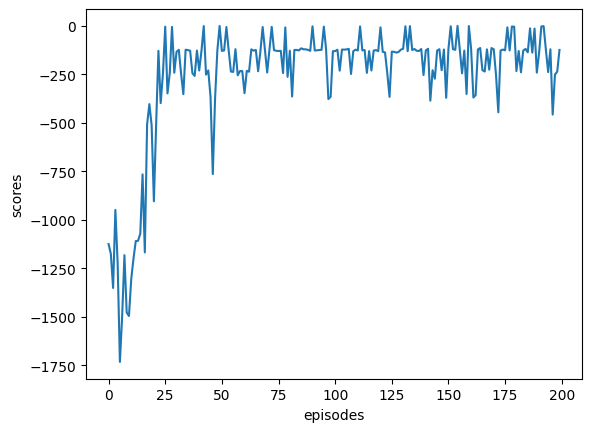

In [7]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    run_ddpg(env)

### Q: Plot the average reward vs number of episode. If you have written your code correctly, you agent should quickly reach an average reward around -250. Analyze your result. Can you get better by changing the hyper parameters? Why?

<span style="color:blue">Due to inherent randomness, results may vary slightly between runs. In the most recent run with the default settings, the agent demonstrated rapid learning during the initial phase, achieving an average reward of approximately −250 after around 25 episodes. However, subsequent performance showed oscillations within the range of 0 to −500, with a concentration between −100 and −300. These results indicate that the agent struggles to consistently converge to an optimal policy.

Optimizing hyperparameters could improve the agent's performance. For example, key parameters like:</span>

- 1, Discount rate (GAMMA): The discount rate balances the emphasis between current and future rewards. A lower discount rate can reduce sensitivity to long-term noise, potentially stabilizing training but sacrificing foresight in policy decisions.
- 2, Batch size (BATCH_SIZE): Larger batch sizes stabilize gradient calculations, mitigating training oscillations. However, excessively large batches may reduce the model's generalization capability.
- 3, Learning rate for the critic/actor (LR_critic/LR_actor): A higher learning rate accelerates training but risks oscillations or even divergence. Conversely, a lower learning rate ensures smoother learning at the cost of slower convergence.
- 4, Network size (LAYER_SIZE): Smaller network layers result in faster computation but may lead to suboptimal performance in complex environments due to their limited capacity. On the other hand, larger networks provide greater modeling power but come with higher computational costs and an increased risk of overfitting.
- 5, Replay (BUFFER_SIZE): A small replay buffer restricts the variety of experiences the agent can sample from, limiting generalization capability. However, it requires less computational cost compared to larger buffers.
- 6, $\tau$ is discussed in the next question.

<span style="color:blue">We tested various combinations of these hyperparameters but eventually retained the default parameters for reporting purposes.</span>

### Q: Explain the role of $\tau$ = 0.005 in this algorithm. Discuss the limiting cases $\tau$ = 0 and $\tau$ = 1. Can you get a better result by changing it? why?


<span style="color:blue">The parameter $\tau$ controls the update of the target network, which is essential for stabilizing learning by providing an appropriate Q-target.<span>

- If $\tau = 0$, the target network is never updated, causing the algorithm to fail to learn, as the Q-target no longer reflects the actual policy. 
- On the other hand, if $\tau = 1$, the target network is fully updated to match the local network, resulting in unstable training.

<span style="color:blue">Tuning $\tau$ can lead to better results because it balances stability and convergence speed. A smaller $\tau$ improves stability but slows convergence, while a larger $\tau$ increases responsiveness but risks instability.<span>

<span style="color:blue">We tested various value of $\tau$ but eventually retained the default parameters for reporting purposes.<span>
